## Setup

In [1]:
source("2022_PSVD_metabolomics/2022_PSVD_metabolomics/R/00_setup.R")

In [2]:
p_load("dplyr", "ggplot2", "mice", "janitor", "POMA", "SummarizedExperiment", "EnhancedVolcano", "ggvenn", "PCAtools", "pheatmap", install = FALSE)

In [65]:
metabol <- read.csv("outputs/01_metabolomics_merged.csv")
metabol <- metabol[2:ncol(metabol)]
metabol <- janitor::clean_names(metabol)
metadata <- read.csv("outputs/01_metadata.csv")
metadata <- metadata[2:ncol(metadata)]

In [66]:
metadata <- metadata %>% filter(sample_id %in% metabol$sample_id)

In [67]:
metadata <- metadata %>% mutate_all(~tidyr::replace_na(.,0))

In [68]:
metabolomics_obj <- PomaSummarizedExperiment(target = metadata, features = metabol[2:ncol(metabol)])

In [7]:
cir_up <- read.csv("outputs/02_cir_up")
cir_down <- read.csv("outputs/02_cir_down")

psvd_up <- read.csv("outputs/02_psvd_up")
psvd_down <- read.csv("outputs/02_psvd_down")

## Venn

In [8]:
venn_dataframe <- list("Cirrhosis down" = cir_down$feature,
                       "Cirrhosis up" = cir_up$feature,
                        "PSVD up" = psvd_up$feature,
                        "PSVD down" = psvd_down$feature)

In [9]:
F1_D <- ggvenn(venn_dataframe,
  fill_color = c("#561965", "#561965", "#87d662", "#87d662"),
  stroke_size = 0.5, set_name_size = 8, text_size = 8)

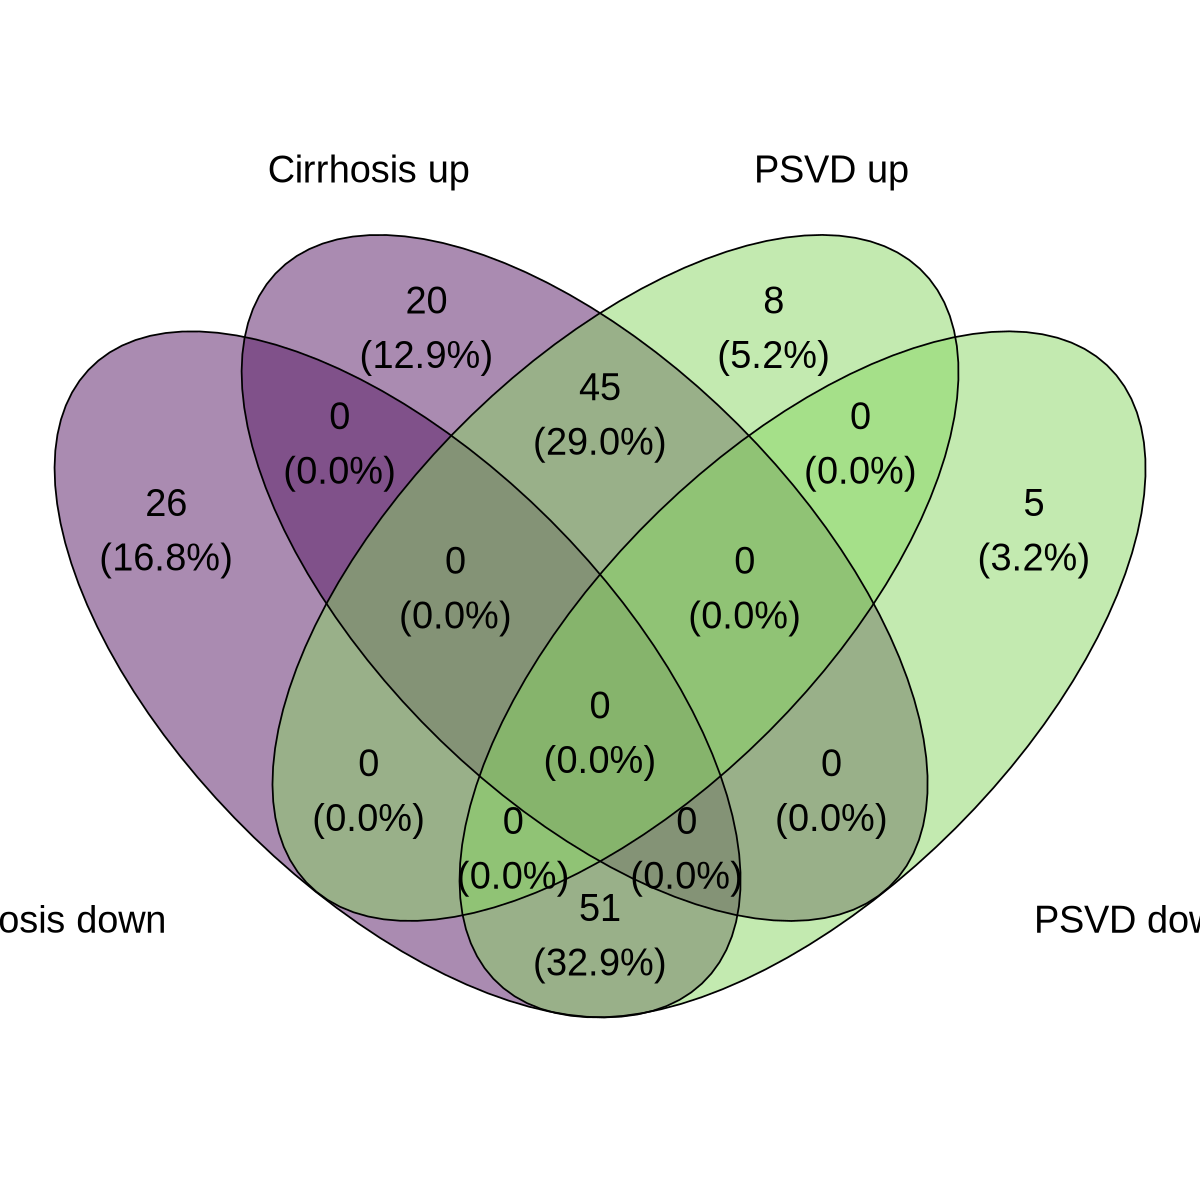

In [10]:
options(repr.plot.width = 10, repr.plot.height = 10)

F1_D

In [11]:
cir_up_psvd_down <- intersect(venn_dataframe$`Cirrhosis down`, venn_dataframe$`PSVD up`)

In [12]:
cir_up_psvd_down

character(0)

In [13]:
psvd_up_cir_down <- intersect(venn_dataframe$`PSVD down`, venn_dataframe$`Cirrhosis up`)

In [14]:
psvd_up_cir_down

character(0)

In [15]:
cirr_up_unique <- setdiff(venn_dataframe$`Cirrhosis up`, c(venn_dataframe$`PSVD up`, venn_dataframe$`PSVD down`))
psvd_up_unique <- setdiff(venn_dataframe$`PSVD up`, c(venn_dataframe$`Cirrhosis up`, venn_dataframe$`Cirrhosis down`))

cirr_down_unique <- setdiff(venn_dataframe$`Cirrhosis down`, c(venn_dataframe$`PSVD up`, venn_dataframe$`PSVD down`))
psvd_down_unique <- setdiff(venn_dataframe$`PSVD down`, c(venn_dataframe$`Cirrhosis up`, venn_dataframe$`Cirrhosis down`))

In [16]:
cirr_up_unique
psvd_up_unique

cirr_down_unique
psvd_down_unique

[1] "TAG(48:0)"                  "TAG(50:2)"                 
 [3] "DAG(34:1)"                  "Propionic acid"            
 [5] "TAG(52:1)"                  "CE(16:1)"                  
 [7] "TAG(54:2)"                  "TAG(48:1)"                 
 [9] "Cer(d38:1)"                 "Palmitoleic acid"          
[11] "TAG(54:3)"                  "DAG(36:2)"                 
[13] "TAG(48:2)"                  "Citric acid+Isocitric acid"
[15] "TAG(54:1)"                  "Erythro-dihydrosphingosine"
[17] "TAG(52:0)"                  "Tyrosine"                  
[19] "TAG(46:0)"                  "PI(36:3)"

[1] "Adipic acid"          "PE(36:2)"             "Cholesterol M (-H2O)"
[4] "Aminoadipic acid"     "Thymine"              "Xanthosine"          
[7] "Pentose"              "Cholic"

[1] "PC(35:2)"                  "Phenylpyruvic acid"       
 [3] "Cer(d42:1)"                "LPC(18:2)"                
 [5] "Pyridinedicarboxylic acid" "PE(38:2)"                 
 [7] "SM(d34:2)"                 "SM(d36:2)"                
 [9] "Pentadecanoic acid"        "LPC(20:4)"                
[11] "Arachidonic acid"          "Dimethyl Succinic acid"   
[13] "SM(d33:1)"                 "PE(38:5)"                 
[15] "SM(d38:2)"                 "PE(42:4)"                 
[17] "PC(38:4)"                  "Capric acid"              
[19] "PC(40:7)"                  "PI(38:4)"                 
[21] "SM(d35:1)"                 "PC(34:2)"                 
[23] "SM(d32:2)"                 "Kynurenine"               
[25] "Cer(d40:1)"                "LPC(20:3)"

[1] "TAG(50:4)"  "Isoleucine" "PC(40:5)"   "Glycine"    "Threonine"

## DimReduction

In [69]:
metadata <- metadata %>% tibble::column_to_rownames("sample_id")

In [86]:
metabolites_mapped <- read.csv("outputs/01_metabolites_mapped.csv")
metabolites_mapped <- metabolites_mapped %>%  mutate(HMDB = janitor::make_clean_names(HMDB))

In [113]:
metabolites_renamed <- assay(metabolomics_obj) %>% as.data.frame() %>% tibble::rownames_to_column("X")

In [129]:
metabolites_mapped <- metabolites_mapped %>% mutate(name_corrected_clean = janitor::make_clean_names(name_corrected))

In [132]:
metabolites_mapped <- metabolites_mapped %>%
  mutate(HMDB = ifelse(!startsWith(HMDB, "hmdb"), name_corrected_clean, HMDB))

In [133]:
indices <- match(metabolites_renamed$X, metabolites_mapped$HMDB)
metabolites_renamed$X <- ifelse(is.na(indices), metabolites_renamed$X, metabolites_mapped$name_corrected[indices])

In [134]:
metabolites_renamed <- metabolites_renamed %>% distinct(X, .keep_all = TRUE) %>% tibble::column_to_rownames("X")

In [22]:
pca_calculated <- pca(metabolites_renamed, metadata = metadata, removeVar = 0.4)

-- removing the lower 40% of variables based on variance



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2



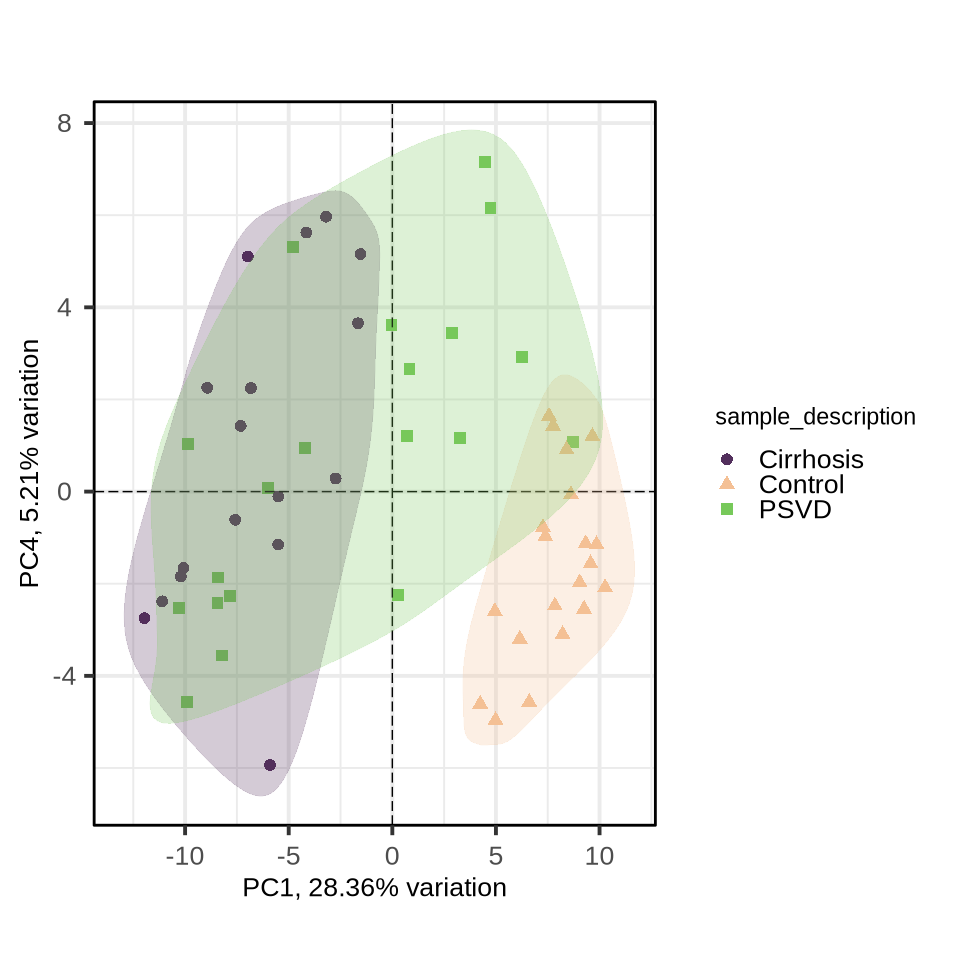

In [23]:
options(repr.plot.width = 8, repr.plot.height = 8)
biplot(pca_calculated, x = "PC1", y = "PC4", lab = NULL, colby = "sample_description", colkey = c(Cirrhosis = "#522f5c",
  PSVD = "#77c95a", Control = "#F4C095"), 
        encircle = TRUE, 
        showLoadings = FALSE, ntopLoadings = 7, sizeLoadingsNames = 2, alphaLoadingsArrow = 0.3, colLoadingsNames = 'red4', hline = 0, vline = 0, 
        legendPosition = "right", legendLabSize = 16, legendIconSize = 3, shape = "sample_description", shapekey = c(`Cirrhosis` = 16, `PSVD` = 15, Control = 17))

In [24]:
df1 <- pca_calculated$rotated
df2 <- pca_calculated$metadata
df1$samples <- rownames(df1)
df2$samples <- rownames(df2)
merged_df <- merge(df1, df2, by = "samples")
group_colors <- c("Cirrhosis" = "#522f5c", "PSVD" = "#77c95a", "Control" = "#F4C095")

In [25]:
library(ggforce)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


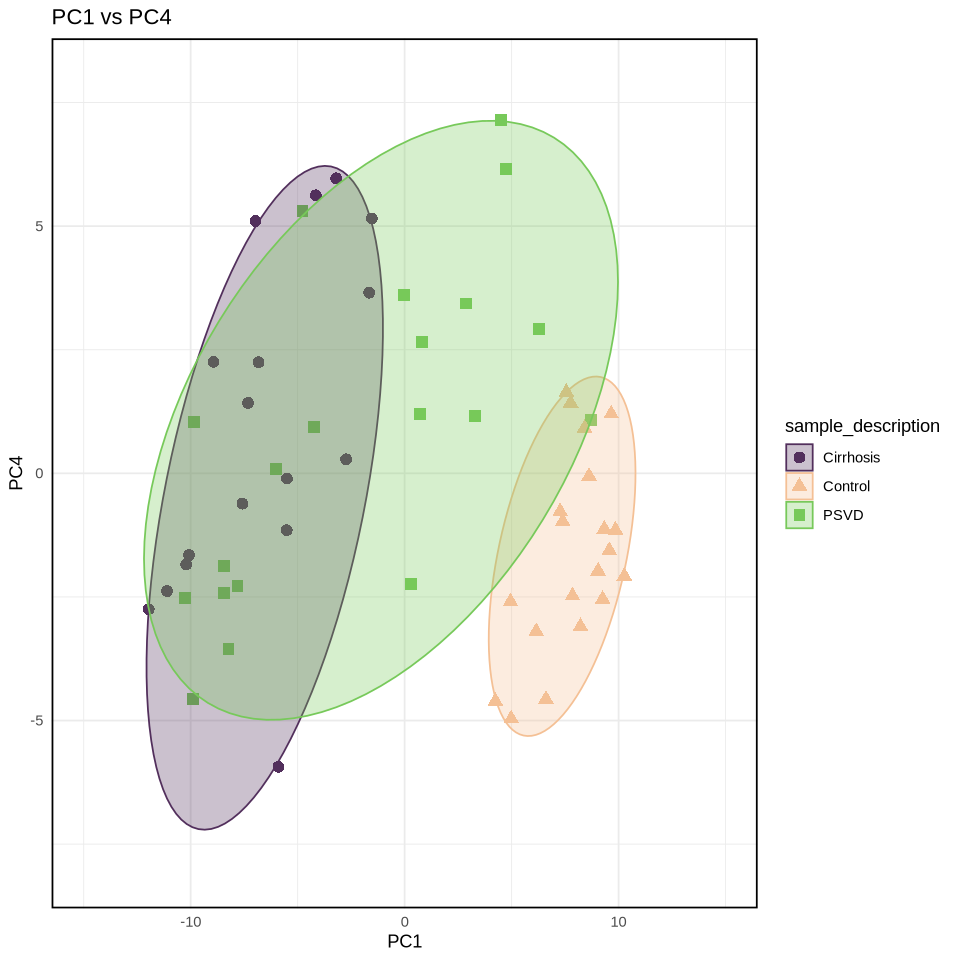

In [26]:
ggplot(merged_df, aes(x = PC1, y = PC4, color = sample_description)) +
  geom_point(aes(shape = sample_description), size = 3) +
  geom_mark_ellipse(aes(fill = sample_description), expand = 0) +
  scale_color_manual(values = group_colors) +
  scale_fill_manual(values = group_colors) +
  scale_shape_manual(values = c("Cirrhosis" = 16, "PSVD" = 15, "Control" = 17)) +
  xlim(-15, 15) +
  ylim(-8, 8) +
  labs(title = "PC1 vs PC4", x = "PC1", y = "PC4") +
  theme_minimal() +
  theme(panel.border = element_rect(color = "black", fill = NA, size = 1))

-- variables retained:

Pyruvic acid, Glutamic acid, Aspartic Acid, Methionine, Acetylcarnitine, Creatine phosphate, PC(32:1), Oleic acid, Palmitoleic acid, PE, TAG(44:1), TAG(42:0), TAG(44:0), TAG(46:2)

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


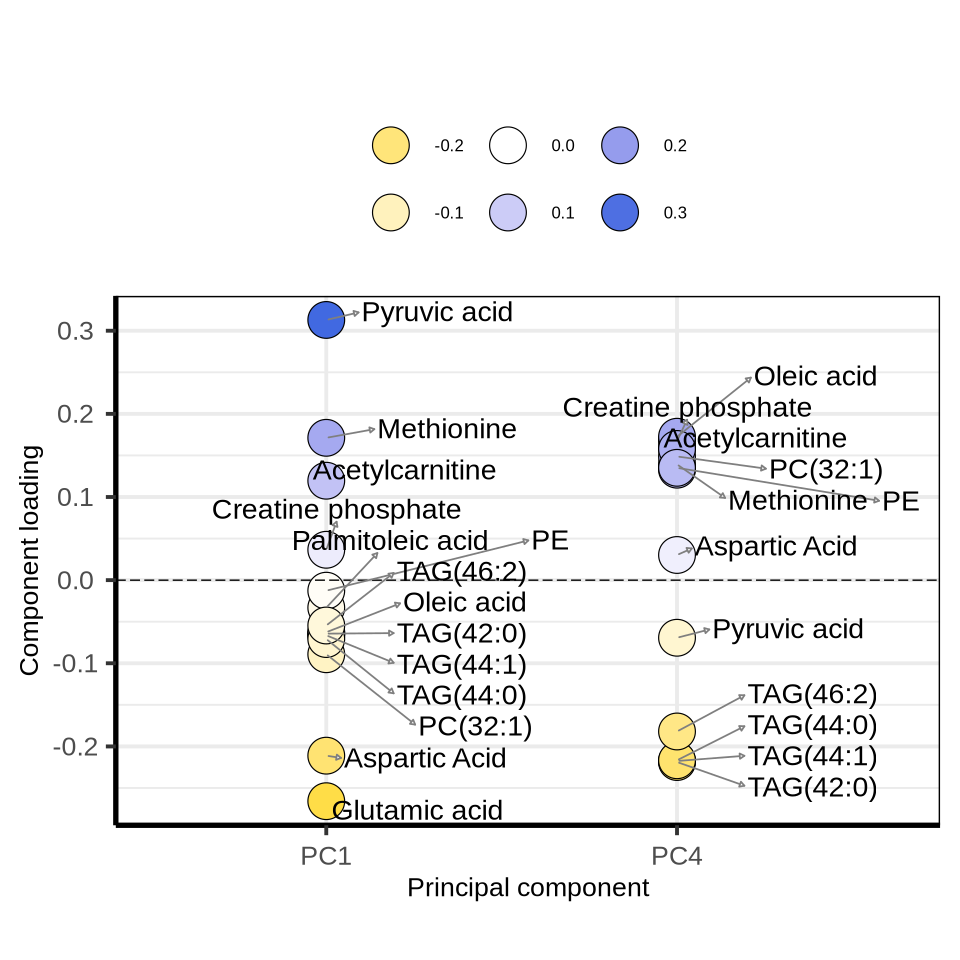

In [27]:
 plotloadings(pca_calculated, components = getComponents(pca_calculated, c(1, 4)), 
                rangeRetain = 0.1, labSize = 6)

In [28]:
pc1_top <- getLoadings(pca_calculated) %>% select(PC1) %>% top_frac(.1) %>% rownames()
pc1_bot <- getLoadings(pca_calculated) %>% select(PC1) %>% top_frac(-.1) %>% rownames()
pc4_top <- getLoadings(pca_calculated) %>% select(PC4) %>% top_frac(.1) %>% rownames()
pc4_bot <- getLoadings(pca_calculated) %>% select(PC4) %>% top_frac(-.1) %>% rownames()

Selecting by PC1


Selecting by PC1
Selecting by PC4
Selecting by PC4


In [29]:
pc1 <- getLoadings(pca_calculated) %>% select(PC1)
pc4 <- getLoadings(pca_calculated) %>% select(PC4)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new c

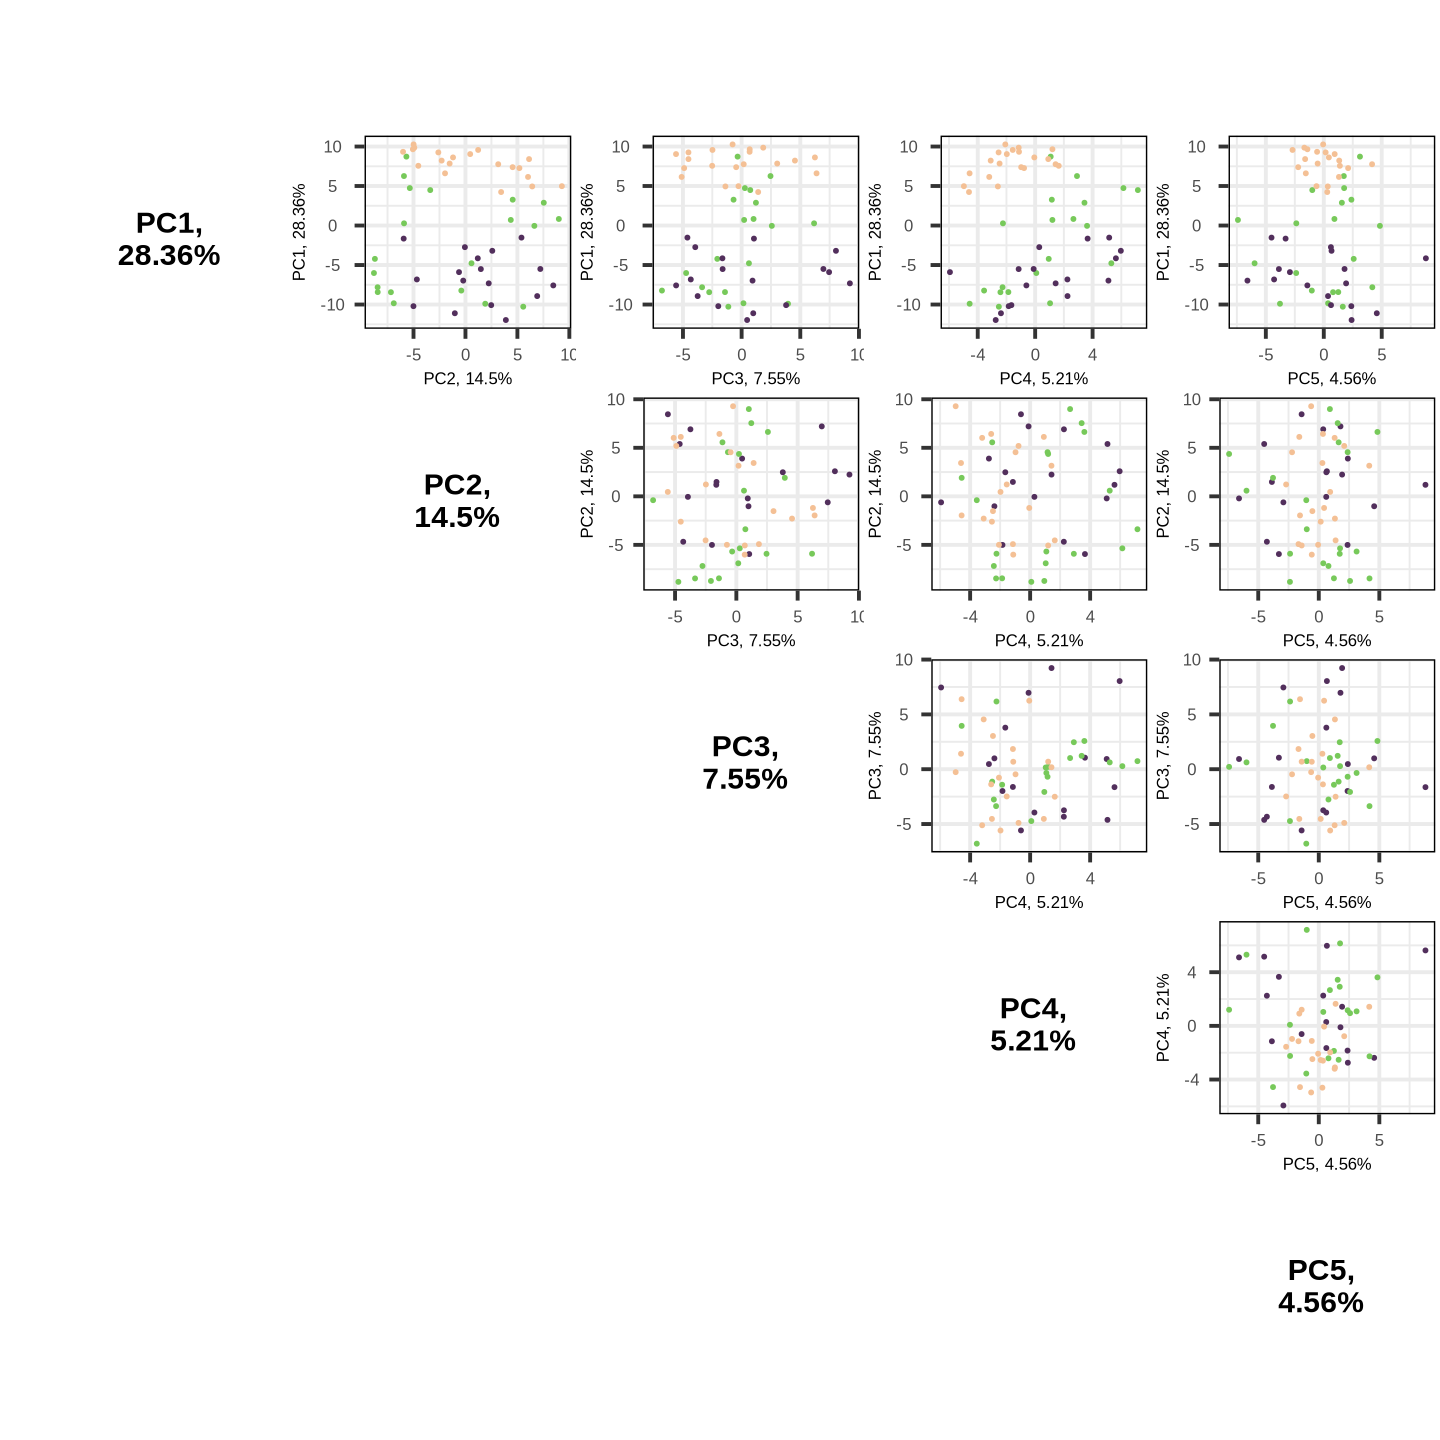

In [30]:
options(repr.plot.width = 12, repr.plot.height = 12)
 pairsplot(pca_calculated, colby = 'sample_description', 
            colkey = c(Cirrhosis = "#522f5c",
  PSVD = "#77c95a", Control = "#F4C095")) 

## Heatmap

In [136]:
metab_of_interest <- c(cirr_up_unique, psvd_up_unique, cirr_down_unique, psvd_down_unique)

In [91]:
cir_cneg <- read.csv("outputs/02_cir_cneg")
psvd_cir <- read.csv("outputs/02_psvd_cir")
psvd_cneg <- read.csv("outputs/02_psvd_cneg")

In [137]:
indices_psvdcneg <- match(psvd_cneg$feature, metabolites_mapped$HMDB)
psvd_cneg$feature <- ifelse(is.na(indices_psvdcneg), psvd_cneg$feature, metabolites_mapped$name_corrected[indices_psvdcneg])

indices_circneg <- match(cir_cneg$feature, metabolites_mapped$HMDB)
cir_cneg$feature <- ifelse(is.na(indices_circneg), cir_cneg$feature, metabolites_mapped$name_corrected[indices_circneg])

indices_psvdcir <- match(psvd_cir$feature, metabolites_mapped$HMDB)
psvd_cir$feature <- ifelse(is.na(indices_psvdcir), psvd_cir$feature, metabolites_mapped$name_corrected[indices_psvdcir])

In [138]:
psvd_cir <- psvd_cir %>% filter(adj.P.Val < 0.05 & logFC > 0.5 | adj.P.Val < 0.05 & logFC < -0.5)
psvd_cneg <- psvd_cneg %>% filter(adj.P.Val < 0.05 & logFC > 0.5 | adj.P.Val < 0.05 & logFC < -0.5)

In [139]:
top_cir <- cir_cneg %>% arrange(adj.P.Val) %>% head(30)

In [140]:
metab_of_interest <- c(psvd_cir$feature, top_cir$feature)

In [141]:
metab_of_interest

[1] "Tyrosine"                "Aspartic Acid"          
 [3] "Adipic acid"             "PC(32:1)"               
 [5] "CE(16:1)"                "Taurocholic acid"       
 [7] "LacCer(d42:2)"           "Glutamic acid"          
 [9] "Aspartic Acid"           "Pyruvic acid"           
[11] "PC(32:0)"                "Cer(d34:1)"             
[13] "CE(22:6)"                "Taurocholic acid"       
[15] "PC(32:0)"                "Isopentyl acetate"      
[17] "PC(39:6)"                "Isocaproic acid"        
[19] "PC(37:4)"                "LPC(18:1)"              
[21] "CE(18:2)"                "LPC(16:0)"              
[23] "Asparagine"              "PC(38:6)"               
[25] "PE(42:6)"                "PC(32:1)"               
[27] "CE(20:4)"                "CE(20:3)"               
[29] "Citramalic acid"         "SM(d36:0)"              
[31] "PC(36:5)"                "PC(34:1)"               
[33] "LacCer(d42:2)"           "SM(d34:0)"              
[35] "Erucic acid"             "alpha-Ketoglutaric acid"
[37] "SM(d40:2)"

In [144]:
mat <- metabolites_renamed #%>% tibble::column_to_rownames("sample_id") %>% t()
mat <- mat %>% as.matrix()
mat <- mat %>% as.data.frame() %>% filter(rownames(.) %in% metab_of_interest) %>% as.matrix()

In [146]:
ann <- colData(metabolomics_obj)
ann <- as.data.frame(ann) %>% arrange(sample_description)

In [147]:
ann_cir <- ann %>% filter(sample_description == "Cirrhosis")
ann_psvd <- ann %>% filter(sample_description == "PSVD")
ann_cneg <- ann %>% filter(sample_description == "Control")

In [148]:
mat_cir <- mat %>% as.data.frame() %>% select(any_of(as.character(rownames(ann_cir))))

mat_psvd <- mat %>% as.data.frame() %>% select(any_of(as.character(rownames(ann_psvd))))

mat_control <- mat %>% as.data.frame() %>% select(any_of(as.character(rownames(ann_cneg))))

In [149]:
mat_cir <- mat_cir %>% mutate(cir_mean = rowMeans(mat_cir)) %>% select(cir_mean)

mat_psvd <- mat_psvd %>% mutate(psvd_mean = rowMeans(mat_psvd)) %>% select(psvd_mean)

mat_control <- mat_control %>% mutate(ctrl_mean = rowMeans(mat_control)) %>% select(ctrl_mean)

In [150]:
mat_means <- cbind(mat_cir, mat_psvd, mat_control) 

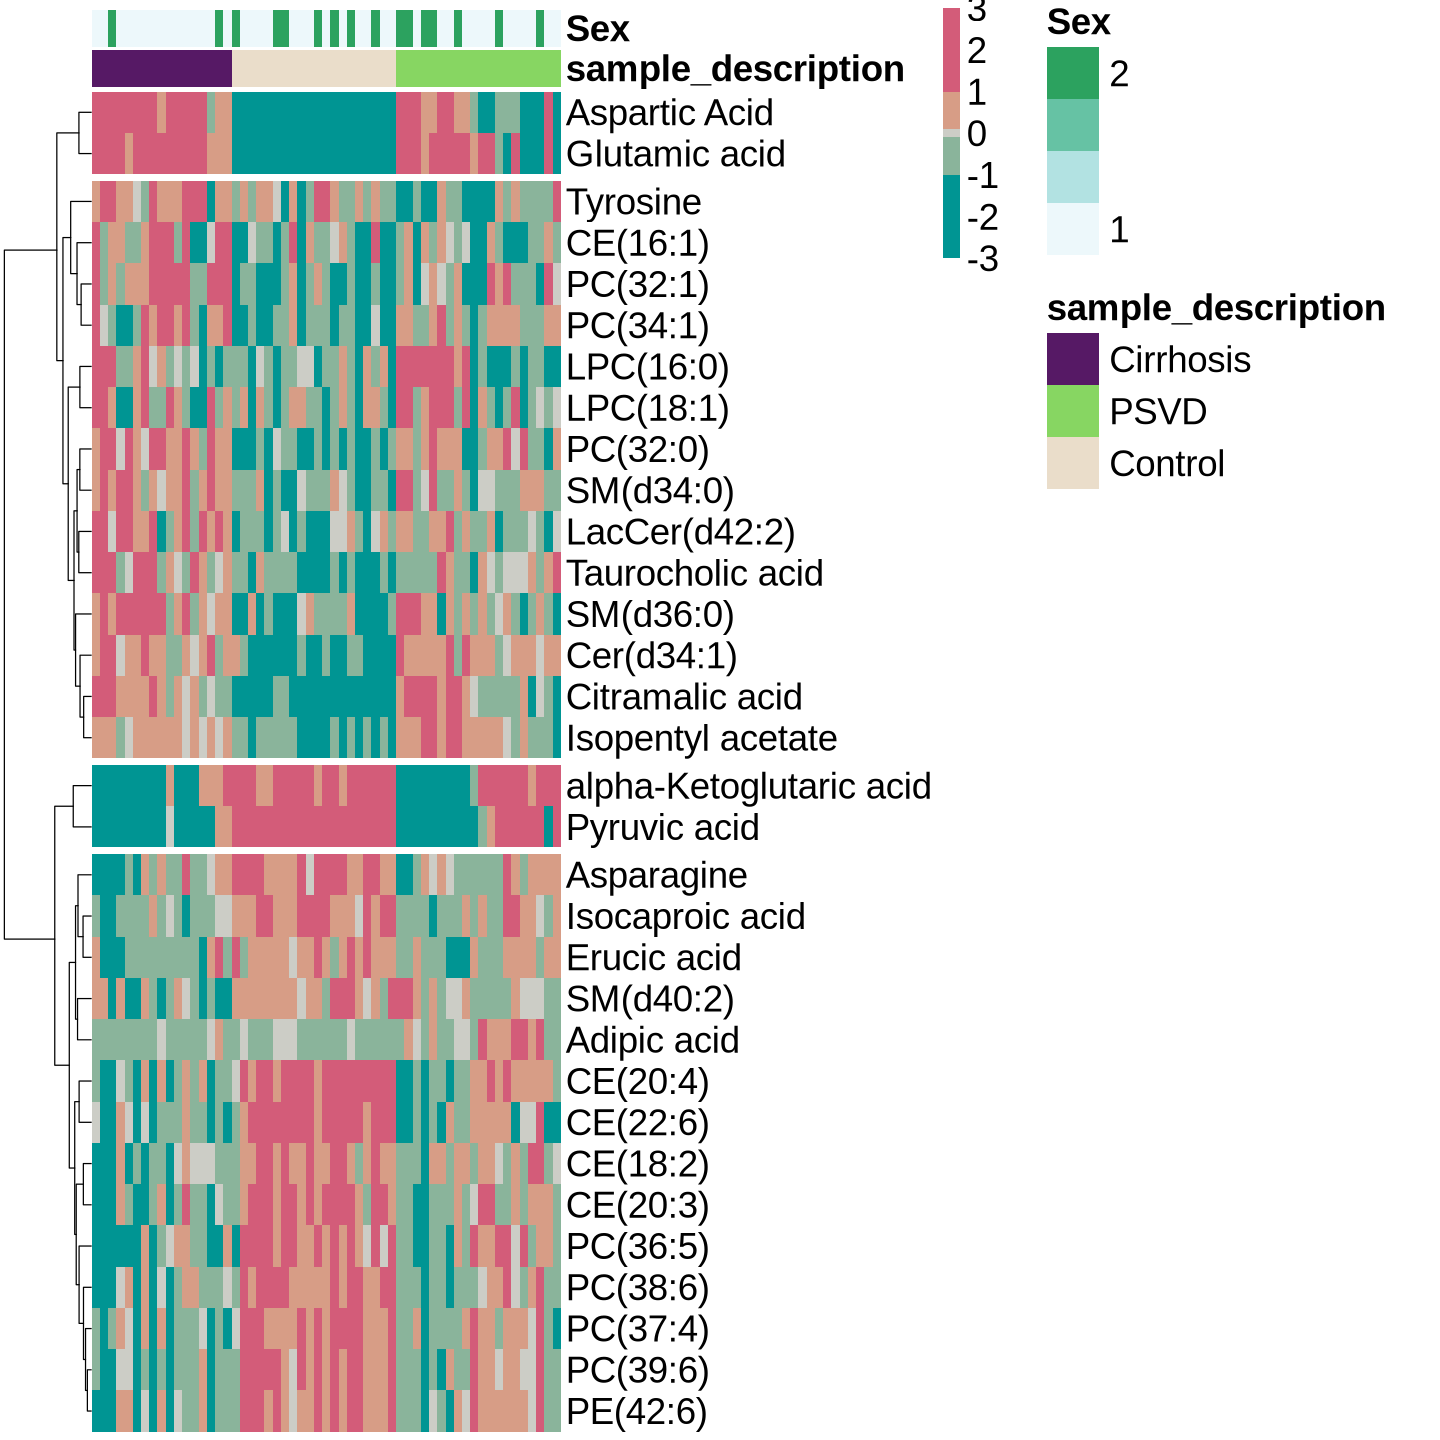

In [151]:
options(repr.plot.width = 12, repr.plot.height = 12)

annotation <- as.data.frame(ann[, c("sample_description", "Sex")])


ann_colors <- list(sample_description = c('Cirrhosis' = "#561965", 'PSVD' = "#87d662", 'Control' = "#EADDCA"))

mat <- mat[, (row.names(ann))]

F1_A <- pheatmap(mat,  color = c("#009593", "#8AB49B", "#CCCDC6", "#D79D86", "#D35C79"), breaks = c(-3, -1, -0.1, 0.1, 1, 3), cluster_rows = TRUE,
  show_rownames = TRUE, cluster_cols = F,
  show_colnames = FALSE, annotation_col = annotation, annotation_colors = ann_colors, clustering_method = "ward.D2",
  cutree_rows = 4, fontsize = 22)

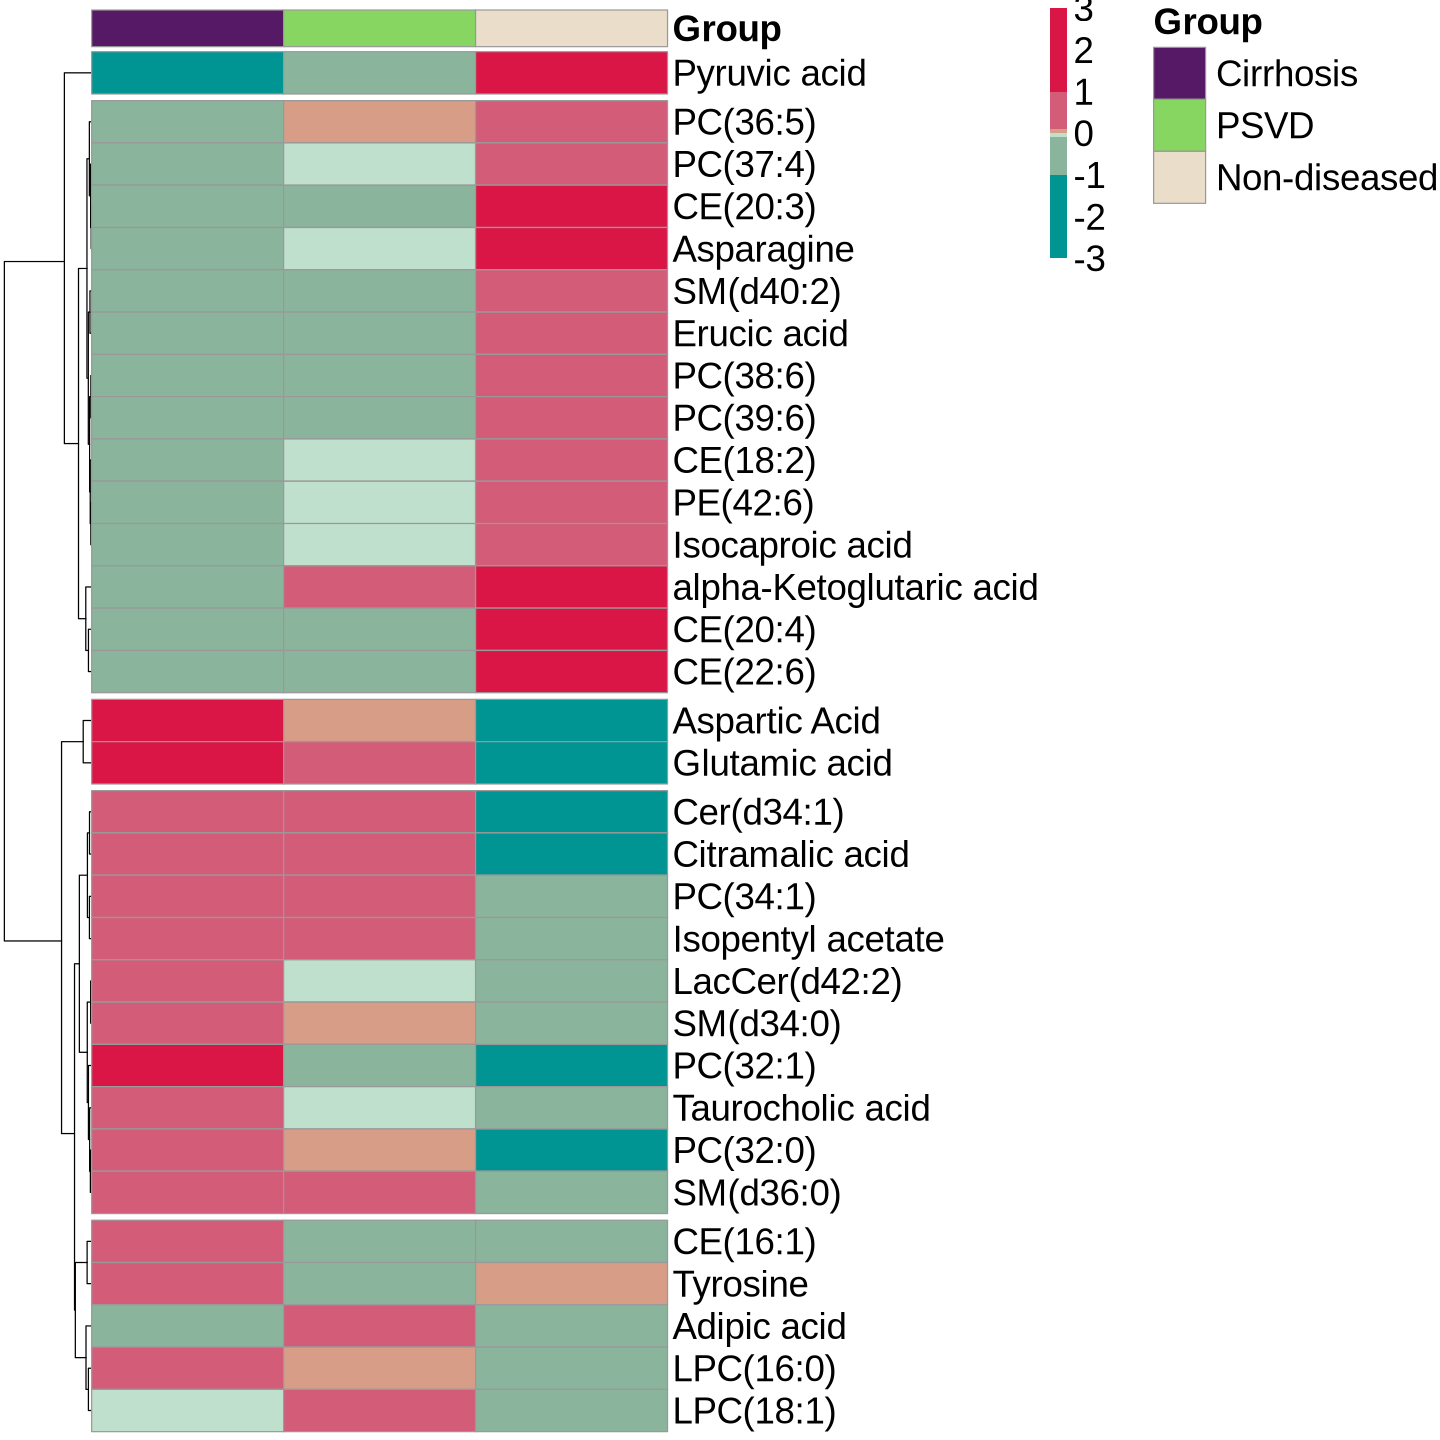

In [152]:
options(repr.plot.width = 12, repr.plot.height = 12)

annotation <- data.frame(rownames = colnames(mat_means), Group = c("Cirrhosis", "PSVD", "Non-diseased")) %>% tibble::column_to_rownames("rownames")


ann_colors <- list(Group = c('Cirrhosis' = "#561965", 'PSVD' = "#87d662", 'Non-diseased' = "#EADDCA"))

#mat <- mat[, (row.names(ann))]

F1_A <- pheatmap(mat_means %>% as.matrix(),  color = c("#009593", "#8AB49B", "#bfe0cc", "#CCCDC6", "#D79D86", "#D35C79", "#d91645"), breaks = c(-3, -1, -0.1, -0.00001, 0.00001, 0.1, 1, 3), cluster_rows = TRUE,
  show_rownames = TRUE, cluster_cols = F,
  show_colnames = FALSE, annotation_col = annotation, annotation_colors = ann_colors, clustering_method = "ward.D2",
  cutree_rows = 5, fontsize = 22)

## Outputs

In [ ]:
pc1_top <- getLoadings(pca_calculated) %>% select(PC1) %>% top_frac(.1) %>% rownames()
pc1_bot <- getLoadings(pca_calculated) %>% select(PC1) %>% top_frac(-.1) %>% rownames()
pc4_top <- getLoadings(pca_calculated) %>% select(PC4) %>% top_frac(.1) %>% rownames()
pc4_bot <- getLoadings(pca_calculated) %>% select(PC4) %>% top_frac(-.1) %>% rownames()

In [300]:
write.csv(pc1_top, file = "outputs/03_pc1_top.csv")
write.csv(pc1_bot, file = "outputs/03_pc1_bpt.csv")
write.csv(pc4_top, file = "outputs/03_pc4_top.csv")
write.csv(pc4_bot, file = "outputs/03_pc4_bot.csv")

In [14]:
write.csv(pc1, file = "outputs/03_pc1.csv")
write.csv(pc4, file = "outputs/03_pc4.csv")

In [11]:
write.csv(cirr_up_unique, file = "outputs/03cirr_up_unique.csv")
write.csv(psvd_up_unique, file = "outputs/03psvd_up_unique.csv")

write.csv(cirr_down_unique, file = "outputs/03cirr_down_unique.csv")
write.csv(psvd_down_unique, file = "outputs/03psvd_down_unique.csv")

In [153]:
ggsave(file = "outputs/03_heatmap.svg", plot = F1_A, width = 12, height = 12, dpi = 300)

In [65]:
ggsave(file = "outputs/03_F1_D.svg", plot = F1_D, width = 12, height = 12, dpi = 300)